# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import cm
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
fileName = '../runs/calibration_2.42^3_10000gamma_1000events.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName = 'photoSensor_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, treeName)
df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, treeName)
df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, treeName)
df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, treeName)
df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, treeName, histDir)
df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, treeName, histDir)
df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, treeName)
df_hits['time'                   ] = get_photosensor_hits_time                    (fileName, treeName)

In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)

# Filter Hits

In [7]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Reconstruct Hit Angle

In [8]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)
df_hits = make_reconstructedVector_direction(df_hits)

100%|██████████| 18374/18374 [00:00<00:00, 71203.53it/s]


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/1100277444.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


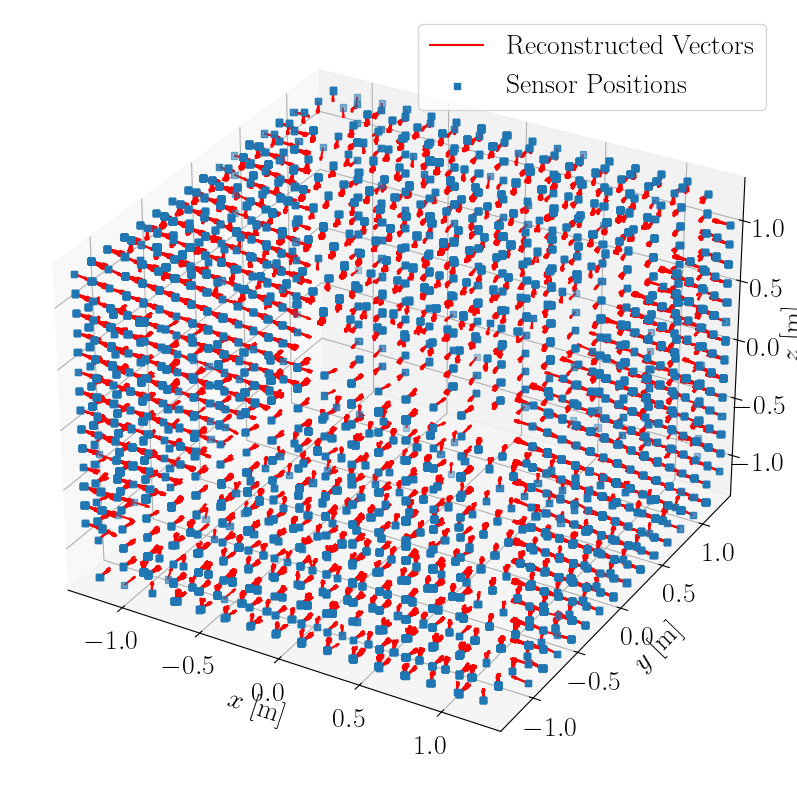

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
#            df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
#            df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
#            label='Reconstructed Points')
ax.quiver(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[2])/1000,
          df_hits['reconstructedVector_direction'].apply(lambda x: x[0]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[1]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[2]),
          label='Reconstructed Vectors',
          length=0.1,
          normalize=True,
          color='red')
ax.scatter(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[2])/1000,
           label='Sensor Positions',
           marker='s')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend()
fig.show()

# Reconstruct Hit With Time

In [10]:
df_hits = make_reconstructedVector_time(df_hits, C_XENON_MM_PER_NS)
df_hits = make_reconstructedPoint_time(df_hits)

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_68684/1246560983.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


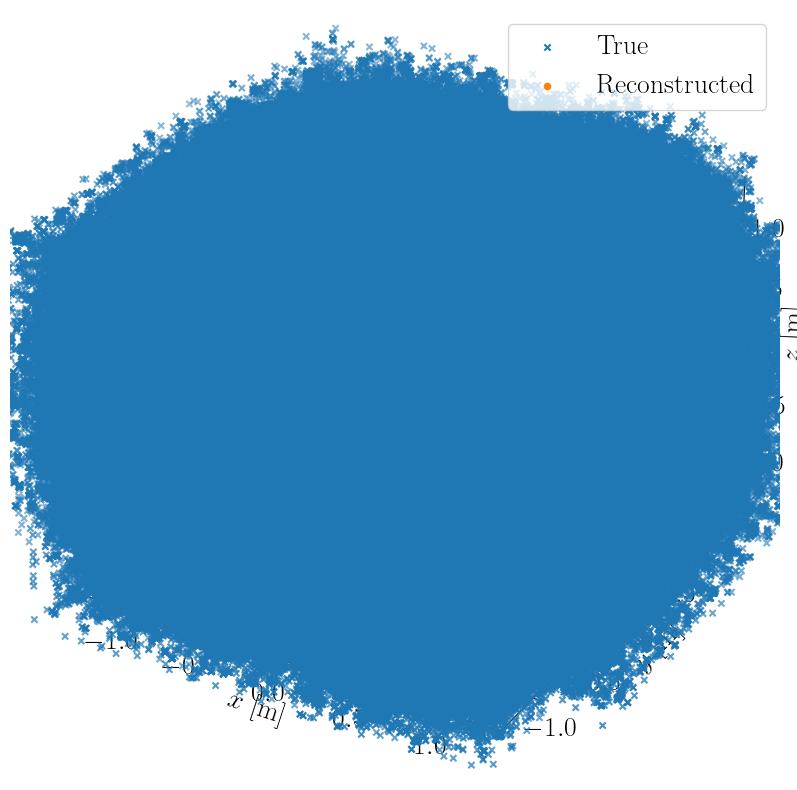

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_time'].apply(lambda x: x[0])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[1])/1000, 
           df_hits['reconstructedPoint_time'].apply(lambda x: x[2])/1000,
           label='Reconstructed')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

# Reconstruct Hit Ideally with Primary Position

In [12]:
df_hits = make_reconstructedPoint_primary_distance(df_hits, df_primary)

furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_primary_distance_r').index
print(df_hits.loc[furthestPoints]['reconstructedPoint_primary_distance_r'])

  0%|          | 18/18374 [00:10<3:00:44,  1.69it/s]


KeyboardInterrupt: 

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_24191/3053773788.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


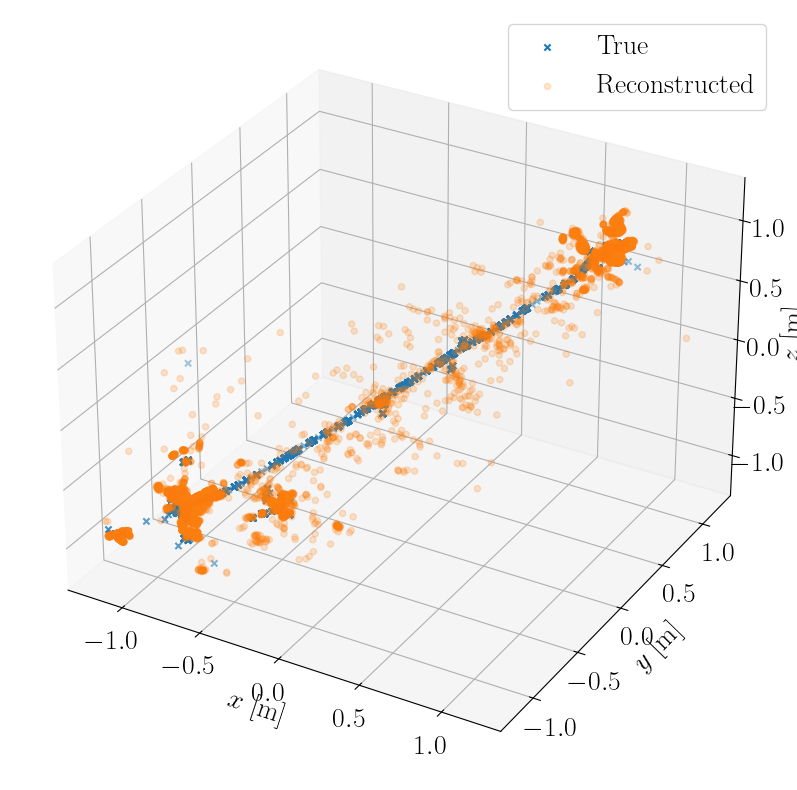

In [13]:
# %matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_primary['position'].apply(lambda x: x[0])/1000, 
           df_primary['position'].apply(lambda x: x[1])/1000, 
           df_primary['position'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[2])/1000,
           label='Reconstructed',
           alpha=0.2)
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_zlim(-1.3, 1.3)
ax.legend(loc='upper right')
fig.show()

mean = 4.92
std = 5.85
1 sigma = 3.90
2 sigma = 17.18
3 sigma = 42.95


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_24191/3759327104.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

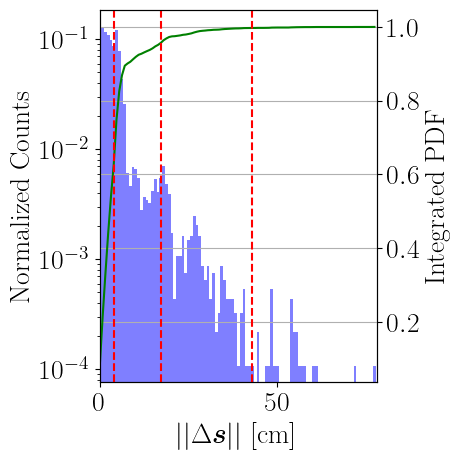

In [ ]:
scale = 10

PDF, hist, scaled_hist, bins = get_PDF(df_hits['reconstructedPoint_primary_distance_r']/scale, nBins=100)
primary_mean = np.mean(df_hits['reconstructedPoint_primary_distance_r']/scale)
primary_std = np.std(df_hits['reconstructedPoint_primary_distance_r']/scale)
primary_sigma_1 = get_CSP('1 sigma', PDF=PDF, bins=bins)
primary_sigma_2 = get_CSP('2 sigma', PDF=PDF, bins=bins)
primary_sigma_3 = get_CSP('3 sigma', PDF=PDF, bins=bins)

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.bar(bins[:-1], scaled_hist, width=np.diff(bins), alpha=0.5, color='blue')
ax1.set_xlabel(r'$|| \Delta \boldsymbol{s} ||$ [cm]')
ax1.set_ylabel('Normalized Counts')
ax1.set_yscale('log')
ax1.set_xlim(0, bins[-1])

ax2 = ax1.twinx()
ax2.plot(bins[:-1], PDF, color='green', label='Histogram')
ax2.set_ylabel('Integrated PDF')

print('mean = {:.2f}'.format(primary_mean))
print('std = {:.2f}'.format(primary_std))
print('1 sigma = {:.2f}'.format(primary_sigma_1))
print('2 sigma = {:.2f}'.format(primary_sigma_2))
print('3 sigma = {:.2f}'.format(primary_sigma_3))

ax2.axvline(primary_sigma_1, color='red', linestyle='--', label='1 Sigma')
ax2.axvline(primary_sigma_2, color='red', linestyle='--', label='2 Sigma')
ax2.axvline(primary_sigma_3, color='red', linestyle='--', label='3 Sigma')
ax2.grid()

fig.tight_layout()
fig.show()

In [ ]:
df_hits['reconstructedPoint_primary_distance_r_x'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[0]) - df_hits['initialPosition'].apply(lambda x: x[0])
df_hits['reconstructedPoint_primary_distance_r_y'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[1]) - df_hits['initialPosition'].apply(lambda x: x[1])
df_hits['reconstructedPoint_primary_distance_r_z'] = df_hits['reconstructedPoint_primary_distance'].apply(lambda x: x[2]) - df_hits['initialPosition'].apply(lambda x: x[2])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_24191/4023523470.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

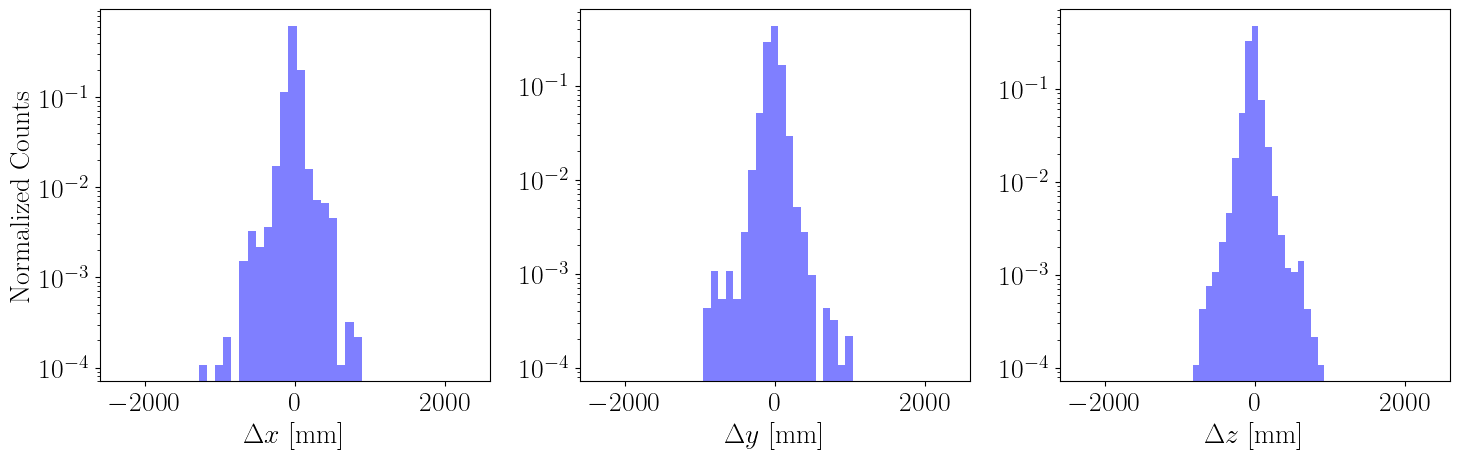

In [ ]:
nBins = 20

_, hist_x, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_primary_distance_r_x'], nBins=nBins)
_, hist_y, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_primary_distance_r_y'], nBins=nBins)
_, hist_z, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_primary_distance_r_z'], nBins=nBins)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(bins_x[:-1], scaled_hist_x, width=np.diff(bins_x), alpha=0.5, color='blue')
axes[0].set_xlabel(r'$\Delta x$ [mm]')
axes[0].set_ylabel('Normalized Counts')
axes[0].set_xlim(-2600, 2600)
axes[0].set_yscale('log')

axes[1].bar(bins_y[:-1], scaled_hist_y, width=np.diff(bins_y), alpha=0.5, color='blue')
axes[1].set_xlabel(r'$\Delta y$ [mm]')
# axes[1].set_ylabel('Normalized Counts')
axes[1].set_xlim(-2600, 2600)
axes[1].set_yscale('log')

axes[2].bar(bins_z[:-1], scaled_hist_z, width=np.diff(bins_z), alpha=0.5, color='blue')
axes[2].set_xlabel(r'$\Delta z$ [mm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-2600, 2600)
axes[2].set_yscale('log')

fig.tight_layout()
fig.show()

# Reconstruct Hit Ideally with Initial Position

In [10]:
df_hits = make_reconstructedPoint_initial_distance(df_hits)

furthestPoints = df_hits.nlargest(5, 'reconstructedPoint_initial_distance_r').index
print(df_hits.loc[furthestPoints]['reconstructedPoint_initial_distance_r'])

7023     1163.382587
7566      975.664111
10860     933.641951
2602      887.785151
14321     886.854077
Name: reconstructedPoint_initial_distance_r, dtype: float64


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/64277404.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


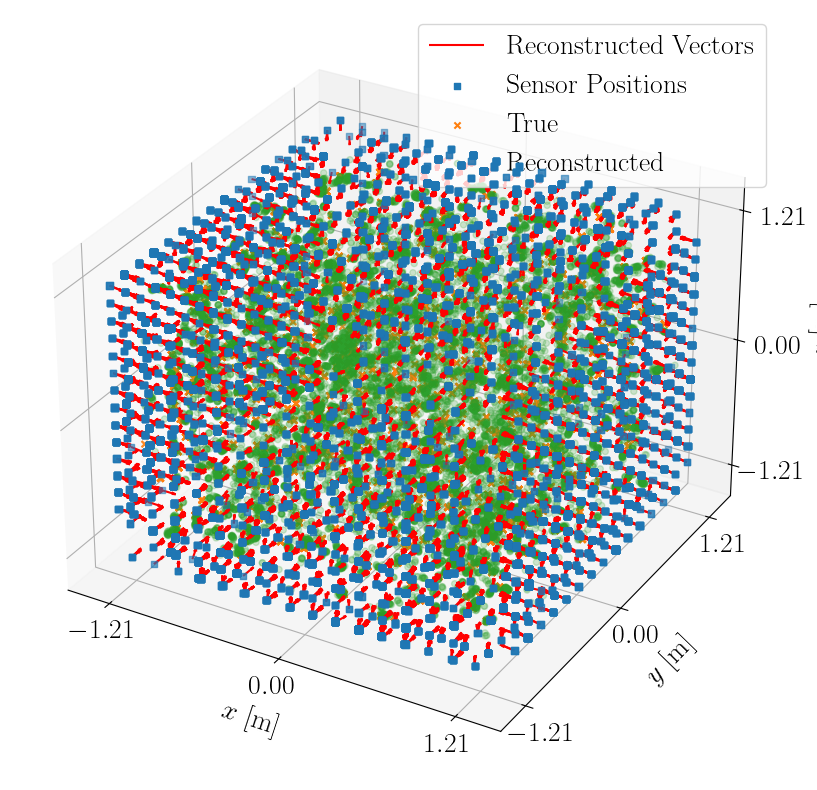

In [11]:
# %matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
          df_hits['sensor_position'].apply(lambda x: x[2])/1000,
          df_hits['reconstructedVector_direction'].apply(lambda x: x[0]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[1]), 
          df_hits['reconstructedVector_direction'].apply(lambda x: x[2]),
          label='Reconstructed Vectors',
          length=0.1,
          normalize=True,
          color='red')
ax.scatter(df_hits['sensor_position'].apply(lambda x: x[0])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[1])/1000, 
           df_hits['sensor_position'].apply(lambda x: x[2])/1000,
           label='Sensor Positions',
           marker='s')
ax.scatter(df_hits['initialPosition'].apply(lambda x: x[0])/1000, 
           df_hits['initialPosition'].apply(lambda x: x[1])/1000, 
           df_hits['initialPosition'].apply(lambda x: x[2])/1000,
           label='True',
           marker='x')
# for i, (sp, rpt) in tqdm.tqdm(enumerate(zip(df_hits['sensor_position'], df_hits['reconstructedPoint_time'])), total=len(df_hits)):
#     ax.quiver(sp[0]/1000, sp[1]/1000, sp[2]/1000,
#               rpt[0]/1000, rpt[1]/1000, rpt[2]/1000,
#               label='Reconstructed Vectors' if i == 0 else None,
#               normalize=True,
#               linewidth=0.5,
#               length=np.linalg.norm(rpt-sp)/1000,
#               alpha=0.02,
#               color='red')
ax.scatter(df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[0])/1000,
           df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[1])/1000,
           df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[2])/1000,
           label='Reconstructed',
           alpha=0.2)

ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 17

percExtra=1.2
ax.set_xlim(-DETECTOR_SIZE_X_MM/2/1000*percExtra, DETECTOR_SIZE_X_MM/2/1000*percExtra)
ax.set_ylim(-DETECTOR_SIZE_Y_MM/2/1000*percExtra, DETECTOR_SIZE_Y_MM/2/1000*percExtra)
ax.set_zlim(-DETECTOR_SIZE_Z_MM/2/1000*percExtra, DETECTOR_SIZE_Z_MM/2/1000*percExtra)

n=3
ax.set_xticks(np.linspace(-DETECTOR_SIZE_X_MM/2/1000, DETECTOR_SIZE_X_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_yticks(np.linspace(-DETECTOR_SIZE_Y_MM/2/1000, DETECTOR_SIZE_Y_MM/2/1000, n))#[[1,-2, n//2]])
ax.set_zticks(np.linspace(-DETECTOR_SIZE_Z_MM/2/1000, DETECTOR_SIZE_Z_MM/2/1000, n))#[[1,-2, n//2]])

ax.tick_params(axis='x', pad=0)
ax.tick_params(axis='y', pad=2)
ax.tick_params(axis='z', pad=10)

ax.legend(loc='upper right')
fig.show()

mean = 106.50
std = 101.55
1 sigma = 105.15
2 sigma = 302.85
3 sigma = 605.20


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/1427618381.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

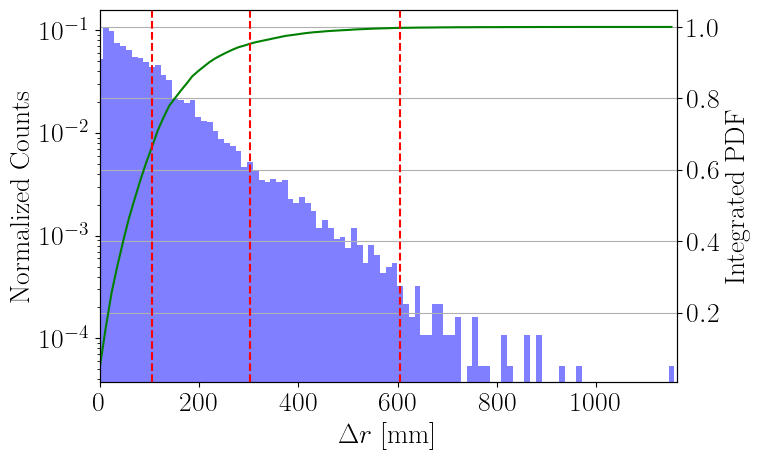

In [12]:
PDF, hist, scaled_hist, bins = get_PDF(df_hits['reconstructedPoint_initial_distance_r'], nBins=100)
initial_mean = np.mean(df_hits['reconstructedPoint_initial_distance_r'])
initial_std = np.std(df_hits['reconstructedPoint_initial_distance_r'])
initial_sigma_1 = get_CSP('1 sigma', PDF=PDF, bins=bins, nBins=bins)
initial_sigma_2 = get_CSP('2 sigma', PDF=PDF, bins=bins, nBins=bins)
initial_sigma_3 = get_CSP('3 sigma', PDF=PDF, bins=bins, nBins=bins)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(bins[:-1], scaled_hist, width=np.diff(bins), alpha=0.5, color='blue')
ax1.set_xlabel(r'$\Delta r$ [mm]')
ax1.set_ylabel('Normalized Counts')
ax1.set_yscale('log')
ax1.set_xlim(0, bins[-1])

ax2 = ax1.twinx()
ax2.plot(bins[:-1], PDF, color='green', label='Histogram')
ax2.set_ylabel('Integrated PDF')

print('mean = {:.2f}'.format(initial_mean))
print('std = {:.2f}'.format(initial_std))
print('1 sigma = {:.2f}'.format(initial_sigma_1))
print('2 sigma = {:.2f}'.format(initial_sigma_2))
print('3 sigma = {:.2f}'.format(initial_sigma_3))

ax2.axvline(initial_sigma_1, color='red', linestyle='--', label='1 Sigma')
ax2.axvline(initial_sigma_2, color='red', linestyle='--', label='2 Sigma')
ax2.axvline(initial_sigma_3, color='red', linestyle='--', label='3 Sigma')
ax2.grid()

fig.tight_layout()
fig.show()

In [13]:
df_hits['reconstructedPoint_initial_distance_r_x'] = df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[0]) - df_hits['initialPosition'].apply(lambda x: x[0])
df_hits['reconstructedPoint_initial_distance_r_y'] = df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[1]) - df_hits['initialPosition'].apply(lambda x: x[1])
df_hits['reconstructedPoint_initial_distance_r_z'] = df_hits['reconstructedPoint_initial_distance'].apply(lambda x: x[2]) - df_hits['initialPosition'].apply(lambda x: x[2])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/3590617500.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

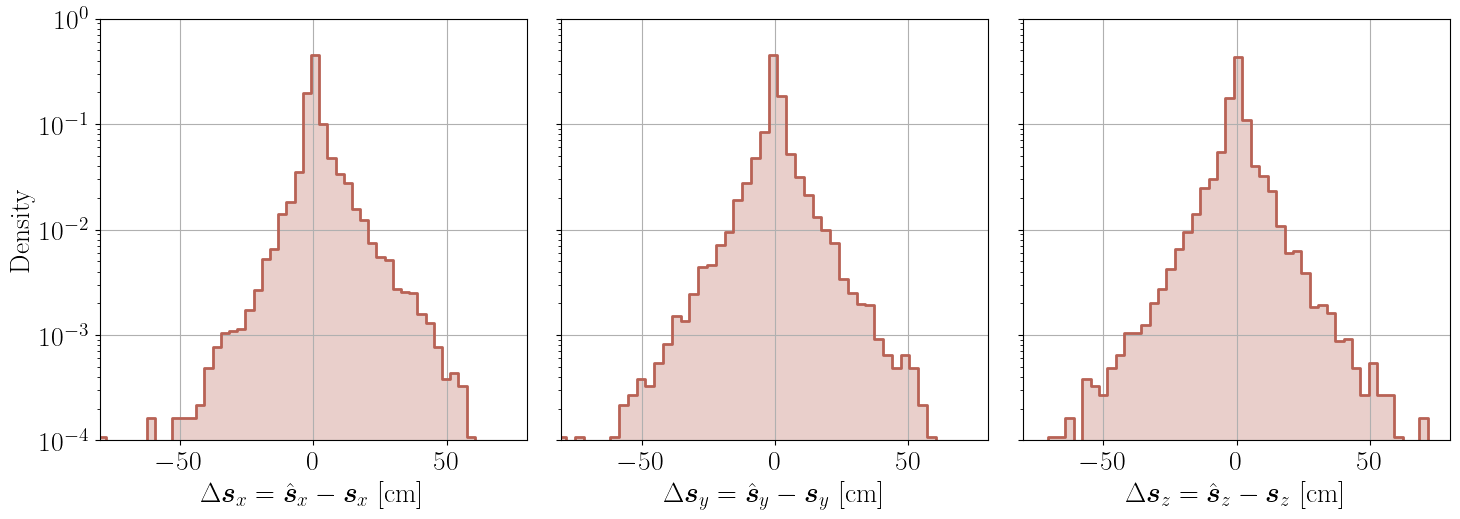

In [14]:
nBins = 50
xLim = 80
lw = 2
scale = 10
twilight = cm.twilight(np.linspace(0,1,40))

_, hist_x, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_initial_distance_r_x']/scale, nBins=nBins)
_, hist_y, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_initial_distance_r_y']/scale, nBins=nBins)
_, hist_z, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_initial_distance_r_z']/scale, nBins=nBins)

bins_x = np.insert(bins_x, 0, bins_x[0] - np.diff(bins_x)[0])
bins_y = np.insert(bins_y, 0, bins_y[0] - np.diff(bins_y)[0])
bins_z = np.insert(bins_z, 0, bins_z[0] - np.diff(bins_z)[0])

scaled_hist_x = np.insert(scaled_hist_x, 0, 0)
scaled_hist_y = np.insert(scaled_hist_y, 0, 0)
scaled_hist_z = np.insert(scaled_hist_z, 0, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5.6))

axes[0].plot(bins_x[:-1], scaled_hist_x, alpha=1, color=twilight[30,:], drawstyle='steps-post', linewidth=lw)
axes[0].fill_between(bins_x[:-1], scaled_hist_x, alpha=0.3, color=twilight[30,:], step='post')#, hatch='//')
axes[0].set_xlabel(r'$\Delta \boldsymbol{s}_x=\hat{\boldsymbol{s}}_{x}-\boldsymbol{s}_{x}$ [cm]')
axes[0].set_ylabel('Density')
axes[0].set_xlim(-xLim, xLim)
axes[0].set_ylim(1e-4, 1)
axes[0].set_yscale('log')
axes[0].grid()

axes[1].plot(bins_y[:-1], scaled_hist_y, alpha=1, color=twilight[30,:], drawstyle='steps-post', linewidth=lw)
axes[1].fill_between(bins_y[:-1], scaled_hist_y, alpha=0.3, color=twilight[30,:], step='post')#, hatch='xx')
axes[1].set_xlabel(r'$\Delta \boldsymbol{s}_y=\hat{\boldsymbol{s}}_{y}-\boldsymbol{s}_{y}$ [cm]')
# axes[1].set_ylabel('Normalized Counts')
axes[1].set_xlim(-xLim, xLim)
axes[1].set_ylim(1e-4, 1)
axes[1].set_yscale('log')
axes[1].set_yticklabels([])
axes[1].grid()

axes[2].plot(bins_z[:-1], scaled_hist_z, alpha=1, color=twilight[30,:], drawstyle='steps-post', linewidth=lw)
axes[2].fill_between(bins_z[:-1], scaled_hist_z, alpha=0.3, color=twilight[30,:], step='post')#, hatch=r'\\')
axes[2].set_xlabel(r'$\Delta \boldsymbol{s}_z=\hat{\boldsymbol{s}}_{z}-\boldsymbol{s}_{z}$ [cm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-xLim, xLim)
axes[2].set_ylim(1e-4, 1)
axes[2].set_yscale('log')
axes[2].set_yticklabels([])
axes[2].grid()

fig.tight_layout()
fig.savefig('../figures/initialReconstructedPointDistance_xyz.pdf', bbox_inches='tight')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/2336635170.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

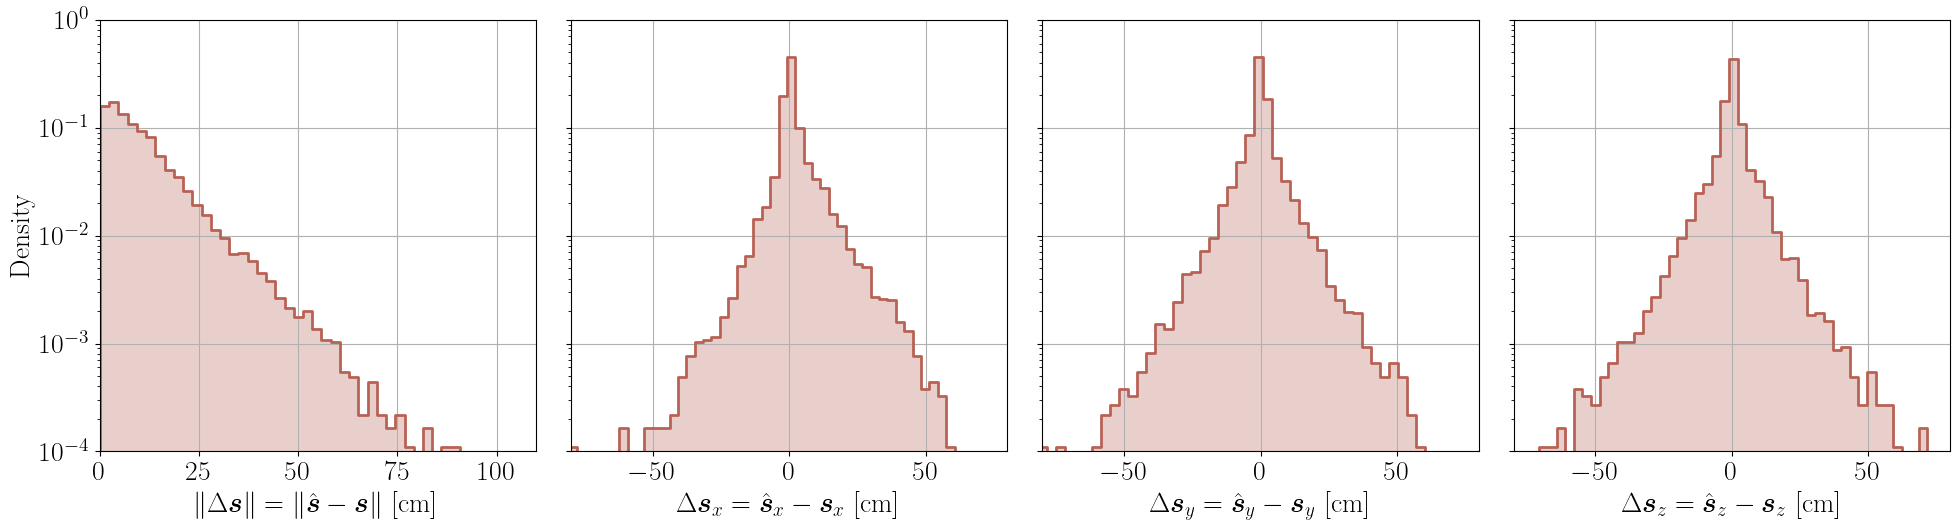

In [21]:
nBins = 50
xLim = 80
lw = 2
scale = 10
twilight = cm.twilight(np.linspace(0,1,40))

_, hist  , scaled_hist  , bins   = get_PDF(df_hits['reconstructedPoint_initial_distance_r'  ]/scale, nBins=nBins)
_, hist_x, scaled_hist_x, bins_x = get_PDF(df_hits['reconstructedPoint_initial_distance_r_x']/scale, nBins=nBins)
_, hist_y, scaled_hist_y, bins_y = get_PDF(df_hits['reconstructedPoint_initial_distance_r_y']/scale, nBins=nBins)
_, hist_z, scaled_hist_z, bins_z = get_PDF(df_hits['reconstructedPoint_initial_distance_r_z']/scale, nBins=nBins)

bins =   np.insert(bins  , 0, bins  [0] - np.diff(bins  )[0])
bins_x = np.insert(bins_x, 0, bins_x[0] - np.diff(bins_x)[0])
bins_y = np.insert(bins_y, 0, bins_y[0] - np.diff(bins_y)[0])
bins_z = np.insert(bins_z, 0, bins_z[0] - np.diff(bins_z)[0])

scaled_hist   = np.insert(scaled_hist  , 0, 0)
scaled_hist_x = np.insert(scaled_hist_x, 0, 0)
scaled_hist_y = np.insert(scaled_hist_y, 0, 0)
scaled_hist_z = np.insert(scaled_hist_z, 0, 0)

scaled_hist_cum = [np.sum([scaled_hist[i] for i in range(j)]) for j in range(len(scaled_hist))]

fig, axes = plt.subplots(1, 4, figsize=(20, 5.7))

# axes[0].set_position([0.1, 0.1, 0.25, 0.8])  # [left, bottom, width, height]
# axes[1].set_position([0.4, 0.1, 0.25, 0.8])
# axes[2].set_position([0.65, 0.1, 0.25, 0.8])
# axes[3].set_position([0.9, 0.1, 0.25, 0.8])

# axes[0].plot(bins[:-1], scaled_hist_cum, alpha=1, color=twilight[8,:], drawstyle='steps-post', linewidth=lw)
axes[0].plot(bins[:-1], scaled_hist    , alpha=1, color=twilight[30,:], drawstyle='steps-post', linewidth=lw)
axes[0].fill_between(bins[:-1], scaled_hist, alpha=0.3, color=twilight[30,:], step='post')#, hatch='//')
axes[0].set_xlabel(r'$\norm{ \Delta \boldsymbol{s} }=\norm{\hat{\boldsymbol{s}}-\boldsymbol{s}}$ [cm]')
axes[0].set_ylabel('Density')
axes[0].set_xlim(0, 110)
axes[0].set_ylim(1e-4, 1)
axes[0].set_yscale('log')
axes[0].grid()

axes[1].plot(bins_x[:-1], scaled_hist_x, alpha=1, color=twilight[30,:], drawstyle='steps-post', linewidth=lw)
axes[1].fill_between(bins_x[:-1], scaled_hist_x, alpha=0.3, color=twilight[30,:], step='post')#, hatch='//')
axes[1].set_xlabel(r'$\Delta \boldsymbol{s}_x=\hat{\boldsymbol{s}}_{x}-\boldsymbol{s}_{x}$ [cm]')
# axes[1].set_ylabel('Density')
axes[1].set_xlim(-xLim, xLim)
axes[1].set_ylim(1e-4, 1)
axes[1].set_yscale('log')
axes[1].set_yticklabels([])
axes[1].grid()

axes[2].plot(bins_y[:-1], scaled_hist_y, alpha=1, color=twilight[30,:], drawstyle='steps-post', linewidth=lw)
axes[2].fill_between(bins_y[:-1], scaled_hist_y, alpha=0.3, color=twilight[30,:], step='post')#, hatch='xx')
axes[2].set_xlabel(r'$\Delta \boldsymbol{s}_y=\hat{\boldsymbol{s}}_{y}-\boldsymbol{s}_{y}$ [cm]')
# axes[2].set_ylabel('Normalized Counts')
axes[2].set_xlim(-xLim, xLim)
axes[2].set_ylim(1e-4, 1)
axes[2].set_yscale('log')
axes[2].set_yticklabels([])
axes[2].grid()

axes[3].plot(bins_z[:-1], scaled_hist_z, alpha=1, color=twilight[30,:], drawstyle='steps-post', linewidth=lw)
axes[3].fill_between(bins_z[:-1], scaled_hist_z, alpha=0.3, color=twilight[30,:], step='post')#, hatch=r'\\')
axes[3].set_xlabel(r'$\Delta \boldsymbol{s}_z=\hat{\boldsymbol{s}}_{z}-\boldsymbol{s}_{z}$ [cm]')
# axes[3].set_ylabel('Normalized Counts')
axes[3].set_xlim(-xLim, xLim)
axes[3].set_ylim(1e-4, 1)
axes[3].set_yscale('log')
axes[3].set_yticklabels([])
axes[3].grid()

fig.tight_layout()
fig.savefig('../figures/initialReconstructedPointDistance_txyz.pdf', bbox_inches='tight')
fig.show()

In [16]:
df_hits = make_relativeVector(df_hits)

18.099727620344066 263.98095902395096
Bin sizes: 4.9176246280721365 2.0


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/2779983785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()/yscale
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/2779983785.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


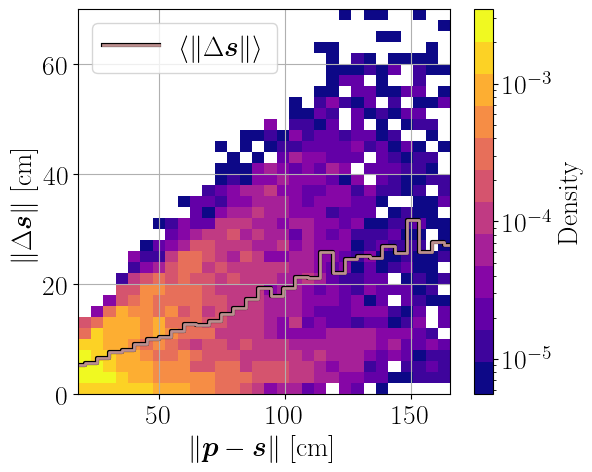

In [34]:
nBins = 50
colors = cm.plasma(np.linspace(0,1,12))
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
colorsmap = ListedColormap(colors)
colors = cm.twilight(np.linspace(0,1,40))

ymax = 70

yscale = 10
xscale = 10

print(df_hits['relativeVector_r'].min()/xscale, df_hits['relativeVector_r'].max()/xscale)

bins_x = np.linspace(df_hits['relativeVector_r'].min()/xscale, df_hits['relativeVector_r'].max()/xscale, nBins + 1)
# bins_x = np.linspace(16, 266, nBins + 1)
# bins_y = np.linspace(df_hits['reconstructedPoint_initial_distance_r'].min(), df_hits['reconstructedPoint_initial_distance_r'].max(), nBins + 1)
bins_y = np.linspace(0, ymax, 35+1)
df_hits['bin'] = pd.cut(df_hits['relativeVector_r']/xscale, bins=bins_x)
average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()/yscale

print("Bin sizes:", np.diff(bins_x)[0], np.diff(bins_y)[0])


fig, ax = plt.subplots(figsize=(6, 5))
hist = ax.hist2d(df_hits['relativeVector_r']/xscale, df_hits['reconstructedPoint_initial_distance_r']/yscale, bins=(bins_x,bins_y), norm=LogNorm(), cmap=colorsmap, density=True)
ax.plot(bins_x[:-1], average_recoPoint_r, marker='o', linestyle='-', color='rosybrown', drawstyle='steps-mid', markersize=0, linewidth=2, label=r'$\langle \norm{ \Delta\boldsymbol{s} } \rangle$', path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax.set_xlabel(r'$ \norm{ \boldsymbol{p} - \boldsymbol{s} }$ [cm]')
ax.set_ylabel(r'$ \norm{ \Delta \boldsymbol{s} }$ [cm]')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_title('Relative Vector vs Reconstructed Point Initial Distance')
index = np.abs(bins_x - 166).argmin()
ax.set_xlim(xmax=bins_x[index])
ax.set_ylim(0, ymax)

ax.grid()
ax.legend(loc='upper left')

cbar = plt.colorbar(hist[3], ax=ax)
# cbar.set_label('Density/5 cm/2 cm')
cbar.set_label('Density')

fig.savefig('../figures/relativeVector_vs_reconstructedPointInitialDistance.pdf', bbox_inches='tight')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/3469386059.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/3469386059.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


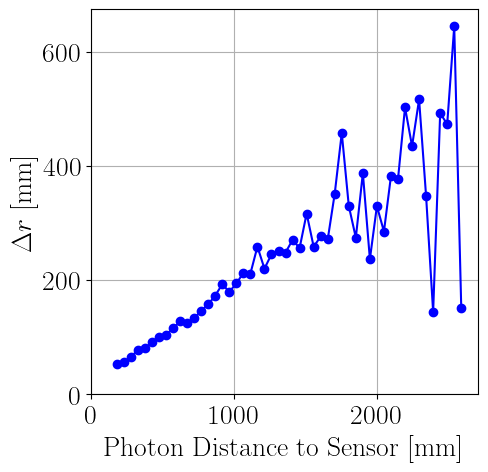

In [18]:
num_bins = 50
bins = np.linspace(df_hits['relativeVector_r'].min(), df_hits['relativeVector_r'].max(), num_bins + 1)
df_hits['bin'] = pd.cut(df_hits['relativeVector_r'], bins=bins)
average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()

fileName = '../figures/photonDistanceToSensor_vs_recoPointInitialDistance_10cm.pkl'
data = {
    'bins': bins,
    'average_recoPoint_r': average_recoPoint_r
}
with open(fileName, 'wb') as f:
    pkl.dump(data, f)

pkl_data = pkl.load(open(fileName, 'rb'))
bins = pkl_data['bins']
average_recoPoint_r = pkl_data['average_recoPoint_r']

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(bins[:-1], average_recoPoint_r, marker='o', linestyle='-', color='b')
ax.set_xlabel(r'Photon Distance to Sensor [mm]')
ax.set_ylabel(r'$\Delta r$ [mm]')
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
# ax.set_aspect('equal')
ax.grid()
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/3877635709.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_11059/3877635709.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


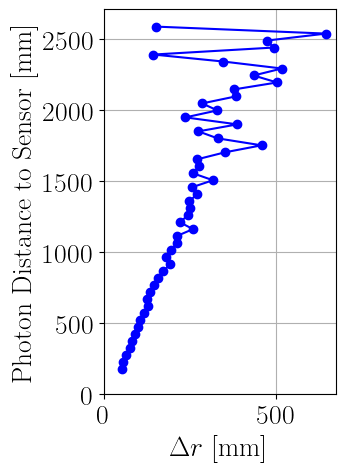

In [19]:
num_bins = 50
bins = np.linspace(df_hits['relativeVector_r'].min(), df_hits['relativeVector_r'].max(), num_bins + 1)
df_hits['bin'] = pd.cut(df_hits['relativeVector_r'], bins=bins)
average_recoPoint_r = df_hits.groupby('bin')['reconstructedPoint_initial_distance_r'].mean()

fig, ax = plt.subplots(figsize=(3, 5))
ax.plot(average_recoPoint_r, bins[:-1], marker='o', linestyle='-', color='b')
ax.set_ylabel(r'Photon Distance to Sensor [mm]')
ax.set_xlabel(r'$\Delta r$ [mm]')
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.grid()

fig.show()

# Performance Reconstruction Methods With Respect to Filter Parameters

In [20]:
print(search_radius)
print(search_number)
print('{:.2f}'.format(np.mean(df_hits['reconstructedPoint_primary_distance_r'])))
print('{:.2f}'.format(np.std(df_hits['reconstructedPoint_primary_distance_r'])))
print('{:.2f}'.format(primary_sigma_1))
print('{:.2f}'.format(primary_sigma_2))
print('{:.2f}'.format(primary_sigma_3))
print('{:.2f}'.format(np.mean(df_hits['reconstructedPoint_initial_distance_r'])))
print('{:.2f}'.format(np.std(df_hits['reconstructedPoint_initial_distance_r'])))
print('{:.2f}'.format(initial_sigma_1))
print('{:.2f}'.format(initial_sigma_2))
print('{:.2f}'.format(initial_sigma_3))
print()
print('[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'
        .format(search_radius, search_number, primary_mean, primary_std, primary_sigma_1, primary_sigma_2, primary_sigma_3, initial_mean, initial_std, initial_sigma_1, initial_sigma_2, initial_sigma_3))

0
0


KeyError: 'reconstructedPoint_primary_distance_r'